**Object Detection with Tensorflow**  
using GPU kernel  
we can't downgrade to tf1.13 in colab GPU kernel.  
so I install tensorflow 1.15, keras 2.3 (downgrade)

In [1]:
!pwd

/content


In [2]:
!pip install tensorflow-gpu==1.15.2

     |████████████████████████████████| 411.0MB 41kB/s 
     |████████████████████████████████| 3.8MB 51.0MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 512kB 44.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f90ab49a44dd42b2d39478b48d2eb53784ab279b76faefbd1580dfa336c50233
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [3]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [4]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.0


Using TensorFlow backend.


In [5]:
# check gpu setting
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/MyDrive/
!cp -r data /content/

/content/gdrive/MyDrive


In [8]:
!rm -rf /content/fast_rcnn/
!mkdir /content/fast_rcnn
!mkdir /content/fast_rcnn/pretrained

%cd /content/fast_rcnn/
!ls

/content/fast_rcnn
pretrained


In [13]:
%cd /content/fast_rcnn/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf faster_rcnn*.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경하고 모델압축푼 폴더로 옮겨줌
!echo "#####renaming pbtxt file name"
!mv /content/fast_rcnn/pretrained/faster_rcnn*.pbtxt /content/fast_rcnn/pretrained/faster_rcnn_resnet50_coco_2018_01_28/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/faster_rcnn_resnet50_coco_2018_01_28"
!ls /content/fast_rcnn/pretrained/faster_rcnn_resnet50_coco_2018_01_28

/content/fast_rcnn/pretrained
##### downloading pretrained weight file and config pbtxt file
--2020-12-30 08:10:06--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.121.128, 2607:f8b0:4001:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.121.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

faster_rcnn_resnet5 100%[===================>] 363.69M   110MB/s    in 3.3s    

2020-12-30 08:10:09 (110 MB/s) - ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2020-12-30 08:10:09--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151

**check single image object detection**

image shape: (633, 806, 3)


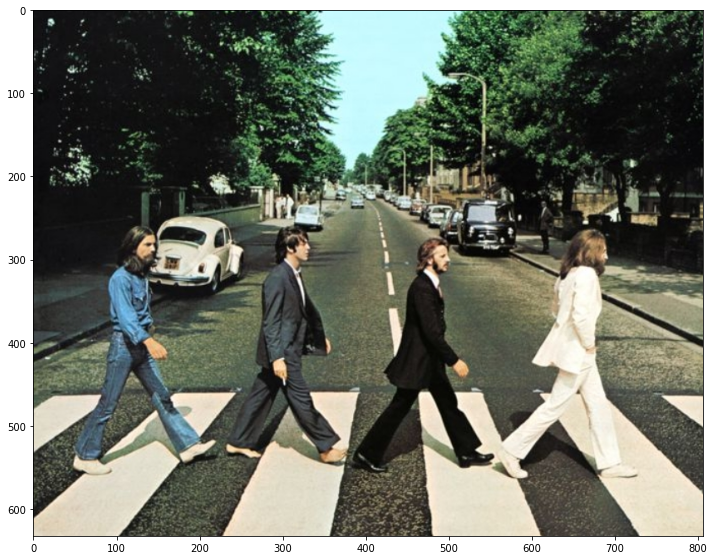

In [10]:
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

default_dir = '/content'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [11]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

type of out: <class 'list'> length of out: 4
[array([19.], dtype=float32), array([[0.99974996, 0.99930656, 0.9980475 , 0.9970794 , 0.9222008 ,
        0.8515701 , 0.80553746, 0.7321973 , 0.7169083 , 0.63502556,
        0.60576946, 0.5482033 , 0.51252395, 0.4640836 , 0.43892807,
        0.41287592, 0.40754658, 0.3961042 , 0.31717572, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.       

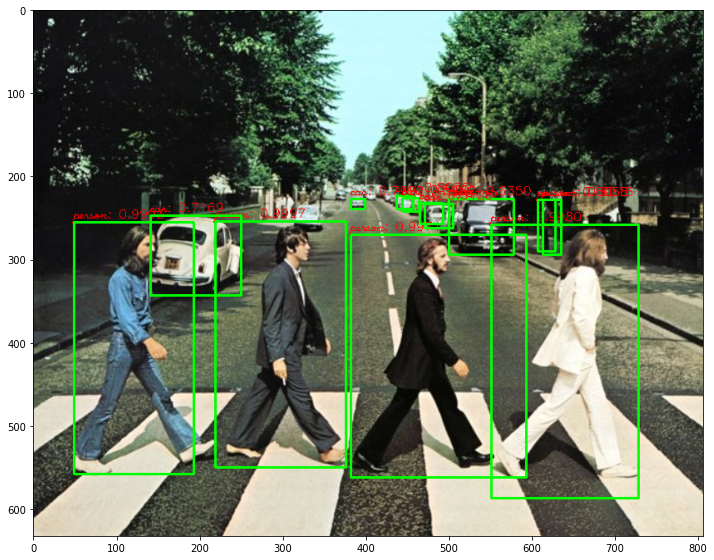

In [14]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

default_rcnn_dir = '/content/fast_rcnn'

# read inference graph
with tf.gfile.FastGFile(os.path.join(default_rcnn_dir, 'pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'), 'rb') as f:
  graph_def = tf.GraphDef() # make empty graph
  graph_def.ParseFromString(f.read()) # parsing probuf file and add to graph

with tf.Session() as sess:
  sess.graph.as_default() # in with block, use sess.graph as default graph
  tf.import_graph_def(graph_def, name='')

  img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
  draw_img = img.copy()
  rows, cols = img.shape[:2]
  #BGR to RGB
  inp = img[:, :, [2, 1, 0]]

  start = time.time()
  # Object Detection
  out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                  sess.graph.get_tensor_by_name('detection_scores:0'),
                  sess.graph.get_tensor_by_name('detection_boxes:0'),
                  sess.graph.get_tensor_by_name('detection_classes:0')],
                  feed_dict = {'image_tensor:0':inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
  print('type of out:', type(out), 'length of out:', len(out))
  print(out)
  green_color = (0, 255, 0)
  red_color = (0, 0, 255)

  # bounding box visualization
  num_detections = int(out[0][0])
  for i in range(num_detections):
    classId = int(out[3][0][i])
    score = float(out[1][0][i])
    bbox = [float(v) for v in out[2][0][i]]
    if score>0.5:
      left = int(bbox[1] * cols)
      top = int(bbox[0] * rows)
      right = int(bbox[3] * cols)
      bottom = int(bbox[2] * rows)
      cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, 2)
      caption = "{}: {:.4f}".format(labels_to_names[classId], score)
      print(caption)
      cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.5, red_color, 1)

  print('Detection 수행시간:', round(time.time()-start, 2), 'sec')

# Session finish
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

**single image object detection function**

Detection time: 6.29


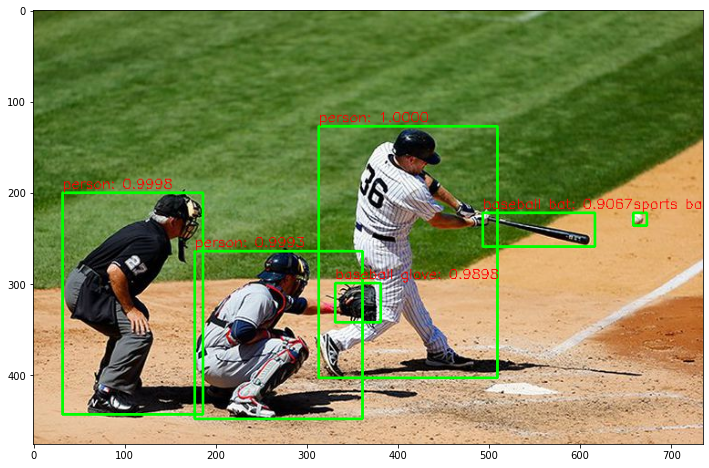

In [19]:
def get_tensor_detected_image(sess, img_array, use_copied_array=True):
  rows, cols = img_array.shape[:2]
  if use_copied_array:
    draw_img_array = img_array.copy()
  else:
    draw_img_array = img_array

  inp = img_array[:, :, [2, 1, 0]]# BGR to RGB
  
  start = time.time()
  # Run Object Detection
  out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                  sess.graph.get_tensor_by_name('detection_scores:0'),
                  sess.graph.get_tensor_by_name('detection_boxes:0'),
                  sess.graph.get_tensor_by_name('detection_classes:0')],
                  feed_dict = {'image_tensor:0':inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
  green_color = (0, 255, 0)
  red_color = (0, 0, 255)

  # bbox visualization
  num_detections = int(out[0][0])
  for i in range(num_detections):
    classId = int(out[3][0][i])
    score = float(out[1][0][i])
    bbox = [float(v) for v in out[2][0][i]]
    if score > 0.5:
      left = int(bbox[1] * cols)
      top = int(bbox[0] * rows)
      right = int(bbox[3] * cols)
      bottom = int(bbox[2] * rows)
      cv2.rectangle(draw_img_array, (left, top), (right, bottom), green_color, 2)
      caption = "{}: {:.4f}".format(labels_to_names[classId], score)
      cv2.putText(draw_img_array, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
  print('Detection time:', round(time.time()-start, 2))
  return draw_img_array

with tf.gfile.FastGFile(os.path.join(default_rcnn_dir, 'pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
with tf.Session() as sess:
  sess.graph.as_default()
  tf.import_graph_def(graph_def, name='')
  img = cv2.imread(os.path.join(default_dir, 'data/image/baseball01.jpg'))
  draw_img = get_tensor_detected_image(sess, img, True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

**Video Object Detection**  
faster rcnn is too slow to detect object in video

In [18]:
default_dir = '/content'
default_rcnn_dir = '/content/fast_rcnn'
video_input_path = os.path.join(default_dir, 'data/video/John_Wick_small.mp4')
video_output_path = os.path.join(default_dir, 'data/output/John_Wick_small.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)

vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)

frame_cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print('frame count:', frame_cnt)

green_color = (0, 255, 0)
red_color = (0, 0, 255)

with tf.gfile.FastGFile(os.path.join(default_rcnn_dir, 'pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'), 'rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

with tf.Session() as sess:
  sess.graph.as_default()
  tf.import_graph_def(graph_def, name='')
  while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
      print('No more frame')
      break
    draw_img_frame = get_tensor_detected_image(sess, frame, False)
    vid_writer.write(draw_img_frame)

vid_writer.release()
cap.release()

frame count: 58.0
Detection time: 5.37
Detection time: 0.14
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.14
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 0.14
Detection time: 0.13
Detection time: 0.13
Detection time: 